# DQN Learning with full episodes
Created 2025-07-14

In [1]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import ipywidgets as widgets
from ipyevents import Event
import time
import gymnasium as gym
import torch
import torch.nn as nn
from typing import Any
from collections import deque
import random
import cv2
from IPython.display import HTML

In [2]:
sys.path.insert(1, str(Path("../..")))
from andreas2048.game import *
from andreas2048 import gym2048
env = gym2048.Env2048()

In [3]:
raise RuntimeError("STOP")

RuntimeError: STOP

### 1st Training

In [13]:
class DQN(nn.Module):
    """ DQN implementation for a 2048 grid """

    def __init__(self, grid_shape: tuple[int, int], action_space: gym.spaces.Space,  device) -> None:
        super(DQN, self).__init__()
        self.device = device
        self.action_space = action_space
        if action_space.shape is None or len(action_space.shape) != 1:
            raise RuntimeError("The action space must provide an 1D shape as property")
        self.grid_size = grid_shape[0]*grid_shape[1]

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(1,grid_shape[1]), padding="valid")
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(grid_shape[0], 1), padding="valid")
        self.conv1.to(self.device)
        self.conv2.to(self.device)
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.grid_size+grid_shape[0]+grid_shape[1], 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, action_space.shape[0])
        )
        self.net.to(self.device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        c1 = self.conv1.forward(x).flatten(start_dim=-2)
        c2 = self.conv2.forward(x).flatten(start_dim=-2)
        x = x.flatten(start_dim=-2)
        c = torch.cat((c1, c2, x), dim=2)
        return self.net(c)
    
    def predict_action(self, x: np.ndarray, mask: np.ndarray|None = None) -> tuple[Action|None, np.ndarray]:
        """ 
        Predict the action according to the probabilities in the grid

        Args:
            x (np.ndarray): The current state encoded as numpy objet (e.g. (4,4) game grid)
            mask (np.ndarray|None): If not None, the mask should be an 1D array of length 4 of zeros and ones.
                The model will only predict actions masked to have an 1. This can be used to filter invalid actions before
                sending the state to the model.

        Returns:
            action (Action): Predicted action using the probabilities provided by the model
            probs (np.ndarray): Probs
        
        """
        t = torch.from_numpy(x).float().to(self.device)
        while len(t.shape) < 4:
            t = t.unsqueeze(0)
        with torch.no_grad():
            q_values = self.forward(t)
        probs = nn.functional.softmax(q_values, dim=1).detach().cpu().numpy()
        if mask is not None and mask.all():
            return None, probs
        return self.action_space.sample(mask=mask, probability=probs[0]), probs


class DQNAgent:
    """ Implements a simple DQN agent """
    
    def __init__( self,
                env: gym2048.Env2048, 
                learning_rate: float = 0.001, 
                gamma: float = 0.99,
                epsilon_decay = 0.005,
                epsilon_min = 0.001,
               ) -> None:
        self.env = env
        self.device = "cpu" #torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model = DQN(grid_shape=env.game.grid.shape, action_space=env.action_space, device=self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.memory: deque[tuple[np.ndarray, Action, int|float, np.ndarray, bool]] = deque(maxlen=10000)
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = 64

    def step(self) -> bool:
        action = self.predict()
        if action is None:
            return False
        state = self.env.game.grid
        next_state, reward, done, truncated, info = env.step(action)
        heuristic = self.heuristic()
        self.memory.append((state[None, :, :], action, float(heuristic), next_state[None, :, :], done or truncated))
        return done or truncated

    def predict(self) -> Action|None:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample(mask=mask)
        return self.model.predict_action(self.env.game.grid, mask=mask)[0]
    
    def predict_greedy(self) -> Action|None:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        return self.model.predict_action(self.env.game.grid, mask=mask)[0]
    
    def get_probs(self) -> dict[Action, str]:
        possible_moves = self.env.game.get_moves()
        mask = np.array([(1 if a in possible_moves else 0) for a in Action])
        probs = self.model.predict_action(self.env.game.grid, mask=mask)[1]
        return {a: f"{probs[a.value]:1.3f}" + (" (invalid)" if mask[a.value] == 0 else "") for a in Action}

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.from_numpy(np.array(states)).float().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        actions = torch.from_numpy(np.array([a.value for a in actions])).to(self.device)
        next_states = torch.from_numpy(np.array(next_states)).float().to(self.device)
        dones = torch.from_numpy(np.array(dones)).float().to(self.device)

        q_values = self.model.forward(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model.forward(next_states).max(1, keepdim=True)[0].squeeze(1)
        targets: torch.Tensor = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * (1 - self.epsilon_decay))

    def heuristic(self) -> float:
        game = self.env.game
        empty = np.count_nonzero(game.grid == 0)
        merges = np.count_nonzero(game.idx_is_merge(game.tile_history[-1]))
        power_sum = np.sum([int(a)**3.5 for a in game.grid.flatten() if a != 0])
        monotonic_left = 0
        monotonic_right = 0
        monotonic_up = 0
        monotonic_down = 0
        for i in range(game.grid.shape[0]):
            for j in range(1,game.grid.shape[1]):
                if game.grid[i,j] > game.grid[i,j-1]:
                    monotonic_right += int(game.grid[i,j])**4 - int(game.grid[i,j-1])**4
                else:
                    monotonic_left += int(game.grid[i,j-1])**4 - int(game.grid[i,j])**4
        for j in range(game.grid.shape[1]):
            for i in range(1,game.grid.shape[0]):
                if game.grid[i,j] > game.grid[i-1,j]:
                    monotonic_down += int(game.grid[i,j])**4 - int(game.grid[i-1,j])**4
                else:
                    monotonic_up += int(game.grid[i-1,j])**4 - int(game.grid[i,j])**4
        #print(empty, merges, power_sum, monotonic_left, monotonic_right, monotonic_up, monotonic_down)
        return float(200_000 + empty*270 + merges*700 - power_sum*11 + max(monotonic_left, monotonic_right, monotonic_up, monotonic_down)*47)

env = gym2048.Env2048(shape=(4,4))
agent = DQNAgent(env=env, epsilon_decay=0.001)
scores = []
highest_tiles = []
move_counts = []
episode = 0

Episode 999 - Reward: 620 - Epsilon: 0.368
Episode 1000 - Reward: 576 - Epsilon: 0.367
Episode 1001 - Reward: 292 - Epsilon: 0.367
Episode 1002 - Reward: 672 - Epsilon: 0.367
Episode 1003 - Reward: 704 - Epsilon: 0.366
Episode 1004 - Reward: 1332 - Epsilon: 0.366
Episode 1005 - Reward: 2096 - Epsilon: 0.365
Episode 1006 - Reward: 836 - Epsilon: 0.365
Episode 1007 - Reward: 616 - Epsilon: 0.365
Episode 1008 - Reward: 124 - Epsilon: 0.364
Episode 1009 - Reward: 404 - Epsilon: 0.364
Episode 1010 - Reward: 848 - Epsilon: 0.364
Episode 1011 - Reward: 648 - Epsilon: 0.363
Episode 1012 - Reward: 1388 - Epsilon: 0.363
Episode 1013 - Reward: 908 - Epsilon: 0.363
Episode 1014 - Reward: 1312 - Epsilon: 0.362
Episode 1015 - Reward: 1252 - Epsilon: 0.362
Episode 1016 - Reward: 628 - Epsilon: 0.361
Episode 1017 - Reward: 724 - Epsilon: 0.361
Episode 1018 - Reward: 712 - Epsilon: 0.361
Episode 1019 - Reward: 392 - Epsilon: 0.360
Episode 1020 - Reward: 440 - Epsilon: 0.360
Episode 1021 - Reward: 2184 

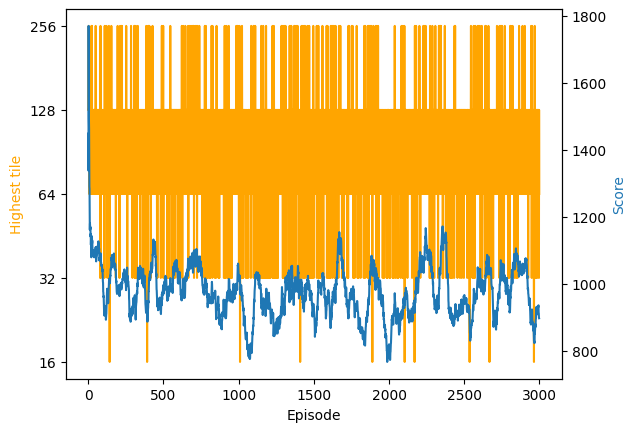

In [15]:
for episode in range(episode, episode+2000):
    obs, info = env.reset()
    done = False

    while not done:
        done = agent.step()
        agent.train_step()

    print(f"Episode {episode} - Score: {env.game.score} - Epsilon: {agent.epsilon:.3f}")
    agent.decay_epsilon()

    scores.append(env.game.score)
    highest_tiles.append(env.game.highest_tile())
    move_counts.append(env.game.move_count)

ax1 = plt.subplot()
ax2 = ax1.twinx()
p1 = ax1.plot(np.log2(highest_tiles), label="Highest tile", c="orange")
p2 = ax2.plot([np.mean(scores[max(0,i-50):i]) for i in range(1,len(scores))], label="Scores")
ax1.set_xlabel("Episode")
ax1.set_ylabel("Highest tile")
ax2.set_ylabel("Score")
ax1.yaxis.label.set_color(p1[0].get_color())
ax2.yaxis.label.set_color(p2[0].get_color())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{2**x:n}"))
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [ ]:
agent.env

208477.2602333264